In [1]:
# Count how many subjects in each group we have

ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [14]:
import pickle
import numpy as np

# s1.0 = male probably

bsnipdir = '/home/anton/Documents/Tulane/Research/data-sav/anton/cohorts/BSNIP/'
demo = pickle.load(open(f'{bsnipdir}/demographics.pkl', 'rb'))

location = {}
fc = []
diags = []

a,b = np.triu_indices(264,1)

for sub in demo['Age_cal']:
    parts = sub.split('.')
    diag = demo['DXGROUP_1'][sub]
    if parts[0] not in location:
        location[parts[0]] = {'Diag': {}}
    if diag not in location[parts[0]]['Diag']:
        location[parts[0]]['Diag'][diag] = 1
    else:
        location[parts[0]]['Diag'][diag] += 1
    p = np.load(f'{bsnipdir}/fc/{sub}_task-unk_fc.npy')
    p = remap(vec2mat(p))[a,b]
    fc.append(p)
    if diag == 'SZP':
        d = 0
    elif diag == 'BPP':
        d = 1
    elif diag == 'SADBPP':
        d = 2
    elif diag == 'SADDEPP':
        d = 3
    elif diag == 'NC':
        d = 4
    else:
        d = 5
    diags.append(d)

for loc in location:
    print(loc)
    tot = 0
    for num in location[loc]['Diag'].values():
        tot += num
    print(tot)
    print(location[loc]['Diag'])

fc = np.stack(fc)
diags = np.array(diags)

print(fc.shape, diags.shape)

Baltimore
279
{'SZP': 68, 'NC': 49, 'BPP': 28, 'SADBPP': 11, 'SADDEPP': 14, 'SADDEPR': 16, 'BPR': 37, 'SZR': 46, 'SADBPR': 10}
Boston
33
{'SZR': 7, 'NC': 9, 'SADBPR': 3, 'SZP': 5, 'BPR': 3, 'BPP': 4, 'SADBPP': 2}
Chicago
238
{'SADBPP': 21, 'SZP': 32, 'NC': 52, 'BPP': 51, 'SADBPR': 12, 'BPR': 40, 'SADDEPR': 5, 'SADDEPP': 5, 'SZR': 20}
Dallas
227
{'BPP': 26, 'SADDEPR': 11, 'SZR': 25, 'NC': 60, 'SZP': 23, 'SADBPR': 30, 'SADBPP': 30, 'BPR': 13, 'SADDEPP': 9}
Detroit
116
{'BPR': 15, 'BPP': 27, 'SZP': 22, 'NC': 23, 'SZR': 19, 'SADBPP': 4, 'SADBPR': 2, 'SADDEPR': 3, 'SADDEPP': 1}
Hartford
351
{'SADBPP': 28, 'SZP': 49, 'SADDEPR': 22, 'BPP': 34, 'SADBPR': 41, 'NC': 49, 'SZR': 64, 'SADDEPP': 15, 'BPR': 49}
(1244, 34716) (1244,)


In [15]:
for d in [0, 1, 2, 3, 4, 5]:
    print(d, np.sum(diags == d))

0 199
1 170
2 96
3 44
4 242
5 493


0.6258503401360545


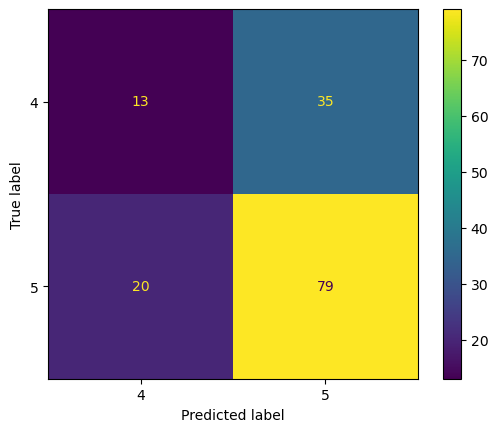

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

fc0 = fc[diags == 0]
fc1 = fc[diags == 5]
fc4 = fc[diags == 4]
fc014 = np.concatenate([fc1, fc4])

diags0 = diags[diags == 0]
diags1 = diags[diags == 5]
diags4 = diags[diags == 4]
diags014 = np.concatenate([diags1, diags4])

xtr, xt, ytr, yt = train_test_split(fc014, diags014, train_size=0.8, stratify=diags014)

reg = LogisticRegression(C=1000).fit(xtr, ytr)
yhat = reg.predict(xt)
print(np.sum(yhat == yt)/len(yhat))
ConfusionMatrixDisplay.from_predictions(yt, yhat)

In [18]:
right = 16+12+37
wrong = 12+12+11+11+5+7
print(right/(right+wrong))

0.5284552845528455
